In [1]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import numpy as np
import networkx as nx
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# Read data

In [15]:
# Read dictionary with municipalities

#link0 = '/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/DTB_BRASIL_MUNICIPIO.csv'
#link0 ='/home/juliane.oliveira/Documents/AESOP data structure/ETL_data/DTB_BRASIL_MUNICIPIO.csv'

#muni = pd.read_csv(link0,sep = ';')

#muni = muni[['UF', 'Nome_UF', 'Mesorregião Geográfica', 'Nome_Mesorregião',
#       'Microrregião Geográfica', 'Nome_Microrregião', 'Município',
#       'Código Município Completo', 'Nome_Município']]

#link1 ='/opt/storage/trusted/aesop/visualization/Mobility/ip_ii_grau_ibge.parquet'

#'/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/Mobility - Road-air-fluvial networks/rodoviario/ip_ii_grau_ibge.parquet'

#dta = pd.read_parquet(link1, engine='pyarrow')

#data= muni.set_index('Código Município Completo').join(dta.set_index('co_ibge')).reset_index()
#data

In [2]:
link1 ='/opt/storage/trusted/aesop/visualization/Mobility/hub_pop_density.csv'

#'/Users/julianeoliveira/Documents/Projects/AESOP/AESOP datalake/Mobility - Road-air-fluvial networks/rodoviario/ip_ii_grau_ibge.parquet'

data = pd.read_csv(link1)

In [3]:
data.columns

Index(['Código Município Completo', '_c0', 'UF2', 'Nome_UF',
       'Mesorregião Geográfica', 'Nome_Mesorregião', 'Microrregião Geográfica',
       'Nome_Microrregião', 'Município', 'Nome_Município', 'uf10', 'co_uf',
       'nm_municipio', 'ind_proxi', 'ind_intermed', 'ind_proxi_per',
       'ind_intermed_per', 'grau', 'densidade_2022', 'populacao_2022', 'key',
       'UF', 'co_munic', 'NOME DO MUNICÍPIO', 'POPULAÇÃO ESTIMADA 2020',
       'POPULAÇÃO ESTIMADA 2019', 'POPULAÇÃO ESTIMADA 2018',
       'POPULAÇÃO ESTIMADA 2017', 'POPULAÇÃO ESTIMADA 2016',
       'POPULAÇÃO ESTIMADA 2015', 'POPULAÇÃO ESTIMADA 2014',
       'POPULAÇÃO ESTIMADA 2013', 'POPULAÇÃO ESTIMADA 2012',
       'POPULAÇÃO ESTIMADA 2011', 'co_ibge'],
      dtype='object')

In [4]:
data.head()

,Código Município Completo,_c0,UF2,Nome_UF,Mesorregião Geográfica,Nome_Mesorregião,Microrregião Geográfica,Nome_Microrregião,Município,Nome_Município,...,POPULAÇÃO ESTIMADA 2019,POPULAÇÃO ESTIMADA 2018,POPULAÇÃO ESTIMADA 2017,POPULAÇÃO ESTIMADA 2016,POPULAÇÃO ESTIMADA 2015,POPULAÇÃO ESTIMADA 2014,POPULAÇÃO ESTIMADA 2013,POPULAÇÃO ESTIMADA 2012,POPULAÇÃO ESTIMADA 2011,co_ibge
0,1302108,105,13,Amazonas,1,Norte Amazonense,2,Japurá,2108,Japurá,...,2755,3265,4205,4660,5125,5599,6083,7448.0,7388.0,1302108
1,1502954,197,15,Pará,6,Sudeste Paraense,19,Parauapebas,2954,Eldorado do Carajás,...,33808,33674,32892,32780,32664,32544,32420,32115.0,31953.0,1502954
2,1702554,327,17,Tocantins,1,Ocidental do Tocantins,1,Bico do Papagaio,2554,Augustinópolis,...,18412,18178,18089,17861,17627,17386,17140,16401.0,16179.0,1702554
3,2104073,519,21,Maranhão,5,Sul Maranhense,20,Gerais de Balsas,4073,Feira Nova do Maranhão,...,8504,8481,8372,8347,8321,8293,8263,8215.0,8171.0,2104073
4,2108207,587,21,Maranhão,3,Centro Maranhense,10,Médio Mearim,8207,Pedreiras,...,39229,39267,38365,38433,38506,38582,39337,39391.0,39419.0,2108207


In [5]:
data = data[['Nome_UF','UF2','co_ibge','Nome_Município', 'ind_proxi', 'ind_intermed', 'ind_proxi_per',
       'ind_intermed_per', 'grau', 'densidade_2022', 'populacao_2022']]

In [6]:
data = data.fillna(0)

In [7]:
data.head()

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022
0,Amazonas,13,1302108,Japurá,0.245972,0.000000,24.597232,0.000000,3.0,0.16,8858
1,Pará,15,1502954,Eldorado do Carajás,0.350491,0.000296,35.049146,0.029642,104.0,9.53,28192
2,Tocantins,17,1702554,Augustinópolis,0.333847,0.000319,33.384663,0.031884,37.0,44.97,17484
3,Maranhão,21,2104073,Feira Nova do Maranhão,0.291007,0.000000,29.100671,0.000000,2.0,4.95,8048
4,Maranhão,21,2108207,Pedreiras,0.346127,0.000123,34.612683,0.012277,36.0,141.38,37050


In [8]:
data = data.assign(ones = 1)

# Proximity index

## Distribution of PI

In [9]:
data[['ind_proxi','grau']].describe().round(2)

,ind_proxi,grau
count,5570.00,5570.00
mean,0.31,23.60
std,0.07,45.95
min,0.00,0.00
25%,0.29,4.00
50%,0.31,11.00
75%,0.36,24.00
max,0.56,1477.00


## Create category to define hus and non hubs by PI crtiterium

In [10]:
data.head()

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones
0,Amazonas,13,1302108,Japurá,0.245972,0.000000,24.597232,0.000000,3.0,0.16,8858,1
1,Pará,15,1502954,Eldorado do Carajás,0.350491,0.000296,35.049146,0.029642,104.0,9.53,28192,1
2,Tocantins,17,1702554,Augustinópolis,0.333847,0.000319,33.384663,0.031884,37.0,44.97,17484,1
3,Maranhão,21,2104073,Feira Nova do Maranhão,0.291007,0.000000,29.100671,0.000000,2.0,4.95,8048,1
4,Maranhão,21,2108207,Pedreiras,0.346127,0.000123,34.612683,0.012277,36.0,141.38,37050,1


In [11]:
data[(data.ind_proxi >= 0.36) & (data.Nome_UF == 'Acre') ]

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones
736,Acre,12,1200401,Rio Branco,0.398500,0.010125,39.850011,1.012517,73.0,41.28,364756,1
1787,Acre,12,1200500,Sena Madureira,0.372202,0.000765,37.220162,0.076537,10.0,1.74,41349,1


In [12]:
data[(data.ind_intermed >= 0.000053) & (data.Nome_UF == 'Acre') ]

,Nome_UF,UF2,co_ibge,Nome_Município,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones
736,Acre,12,1200401,Rio Branco,0.398500,0.010125,39.850011,1.012517,73.0,41.28,364756,1
1787,Acre,12,1200500,Sena Madureira,0.372202,0.000765,37.220162,0.076537,10.0,1.74,41349,1
2047,Acre,12,1200203,Cruzeiro do Sul,0.285458,0.001851,28.545847,0.185100,11.0,10.46,91888,1


In [23]:
data.loc[(data['ind_proxi'] < 0.36),'hub_ind_proxi'] = 0

data.loc[(data['ind_proxi'] >= 0.36),'hub_ind_proxi'] = 1

In [28]:
cutPI = data[data.hub_ind_proxi == 1]#.sort_values(by=['ind_proxi'],ascending=False)

## Number of hubs by state given by PI

In [ ]:
data[data.ind_proxi >= 0.36].groupby(['Nome_UF'])['ones'].count()

In [38]:
#cutPI[cutPI['Nome_UF'] == 'Acre']

In [25]:
#import seaborn as sns
#from fitter import Fitter, get_common_distributions, get_distributions

#https://medium.com/the-researchers-guide/finding-the-best-distribution-that-fits-your-data-using-pythons-fitter-library-319a5a0972e9

#f = Fitter(data['ind_proxi'],
#           distributions=['gamma',
#                          'lognorm',
#                          "beta",
#                          "burr",
#                          "norm"])
#f.fit()
#f.summary()


# Example 1: Plot distribution of values in Marks column
#data['ind_proxi'].plot(kind='kde')
#f.get_best(method = 'sumsquare_error')

# Betweenness index

## Distribution of BI

In [30]:
data['ind_intermed'].describe()#*100

count    5570.000000
mean        0.000384
std         0.004374
min         0.000000
25%         0.000000
50%         0.000002
75%         0.000053
max         0.283094
Name: ind_intermed, dtype: float64

## Create category to define hus and non hubs by BI crtiterium

In [24]:
data.loc[(data['ind_intermed'] < 0.000053),'hub_ind_intermed'] = 0

data.loc[(data['ind_intermed'] >= 0.000053),'hub_ind_intermed'] = 1

In [32]:
cutII = data[data.hub_ind_intermed == 1]

## Number of hubs by state given by BI

In [37]:
#data[data.ind_intermed >= 0.000053]
cutII.groupby(['Nome_UF'])['ones'].count()

Nome_UF
Acre                     3
Alagoas                 17
Amapá                    1
Amazonas                 5
Bahia                  108
Ceará                   54
Distrito Federal         1
Espírito Santo          25
Goiás                   47
Maranhão                50
Mato Grosso             53
Mato Grosso do Sul      28
Minas Gerais           227
Paraná                 104
Paraíba                 44
Pará                    35
Pernambuco              60
Piauí                   53
Rio Grande do Norte     17
Rio Grande do Sul      110
Rio de Janeiro          27
Rondônia                13
Roraima                  2
Santa Catarina          77
Sergipe                 16
São Paulo              190
Tocantins               24
Name: ones, dtype: int64

In [35]:
#cutII.sort_values(by=['ind_intermed'],ascending=False)

In [36]:
#cutII['Nome_UF'].unique()

# Analysis of PI and BI

## Count the number of municipalities by state that are hubs with both indexes

In [34]:
for value in cutII['Nome_UF'].unique():
    print(value, len(list(set(cutII[cutII['Nome_UF'] == value]
          .nm_municipio) & set(cutPI[cutPI['Nome_UF'] == value] 
          .nm_municipio))))

Pará 14
Tocantins 13
Maranhão 23
Paraíba 37
Bahia 103
Minas Gerais 184
São Paulo 186
Pernambuco 58
Alagoas 14
Paraná 79
Rio Grande do Sul 45
Mato Grosso 37
Rondônia 9
Piauí 48
Mato Grosso do Sul 22
Santa Catarina 52
Rio de Janeiro 22
Espírito Santo 14
Rio Grande do Norte 12
Goiás 37
Sergipe 15
Ceará 49
Amazonas 0
Acre 2
Distrito Federal 1
Amapá 0
Roraima 0


## Hubs of commun hubs

In [25]:
data.loc[((data['hub_ind_intermed'] == 1)&(data['hub_ind_proxi'] == 1)),'hub_inter'] = 1
data.loc[((data['hub_ind_intermed'] == 1)&(data['hub_ind_proxi'] == 0)),'hub_inter'] = 1

In [26]:
data.hub_inter = data.hub_inter.fillna(0)

In [28]:
data[['Nome_UF','co_ibge','Nome_Município','hub_ind_proxi','hub_ind_intermed', 'hub_inter']].to_csv('/home/juliane.oliveira/Documents/GitHub/Reproducibility results_paper2/data/lists_of_hubs.csv')

In [29]:
data.to_csv('/home/juliane.oliveira/Documents/GitHub/Reproducibility results_paper2/data/hubs_IBGE_metric.csv')

In [14]:
data.head()

,Nome_UF,UF2,co_ibge,nm_municipio,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones,hub_ind_proxi,hub_ind_intermed,hub_inter
0,Amazonas,13,1302108,JAPURÁ,0.245972,0.000000,24.597232,0.000000,3.0,0.16,8858,1,0.0,0.0,0.0
1,Pará,15,1502954,ELDORADO DOS CARAJÁS,0.350491,0.000296,35.049146,0.029642,104.0,9.53,28192,1,0.0,1.0,1.0
2,Tocantins,17,1702554,AUGUSTINÓPOLIS,0.333847,0.000319,33.384663,0.031884,37.0,44.97,17484,1,0.0,1.0,1.0
3,Maranhão,21,2104073,FEIRA NOVA DO MARANHÃO,0.291007,0.000000,29.100671,0.000000,2.0,4.95,8048,1,0.0,0.0,0.0
4,Maranhão,21,2108207,PEDREIRAS,0.346127,0.000123,34.612683,0.012277,36.0,141.38,37050,1,0.0,1.0,1.0


# Correlations and countings of hubs and non hubs

In [54]:
data.hub_inter.value_counts()

0.0    4179
1.0    1391
Name: hub_inter, dtype: int64

In [58]:
data.head()

,Nome_UF,UF2,co_ibge,nm_municipio,ind_proxi,ind_intermed,ind_proxi_per,ind_intermed_per,grau,densidade_2022,populacao_2022,ones,hub_ind_proxi,hub_ind_intermed,hub_inter
0,Amazonas,13,1302108,JAPURÁ,0.245972,0.000000,24.597232,0.000000,3.0,0.16,8858,1,0.0,0.0,0.0
1,Pará,15,1502954,ELDORADO DOS CARAJÁS,0.350491,0.000296,35.049146,0.029642,104.0,9.53,28192,1,0.0,1.0,1.0
2,Tocantins,17,1702554,AUGUSTINÓPOLIS,0.333847,0.000319,33.384663,0.031884,37.0,44.97,17484,1,0.0,1.0,1.0
3,Maranhão,21,2104073,FEIRA NOVA DO MARANHÃO,0.291007,0.000000,29.100671,0.000000,2.0,4.95,8048,1,0.0,0.0,0.0
4,Maranhão,21,2108207,PEDREIRAS,0.346127,0.000123,34.612683,0.012277,36.0,141.38,37050,1,0.0,1.0,1.0


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5570 entries, 0 to 5569
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Nome_UF           5570 non-null   object 
 1   UF2               5570 non-null   int64  
 2   co_ibge           5570 non-null   int64  
 3   nm_municipio      5570 non-null   object 
 4   ind_proxi         5570 non-null   float64
 5   ind_intermed      5570 non-null   float64
 6   ind_proxi_per     5570 non-null   float64
 7   ind_intermed_per  5570 non-null   float64
 8   grau              5570 non-null   float64
 9   densidade_2022    5570 non-null   float64
 10  populacao_2022    5570 non-null   int64  
 11  ones              5570 non-null   int64  
 12  hub_ind_proxi     5570 non-null   float64
 13  hub_ind_intermed  5570 non-null   float64
 14  hub_inter         5570 non-null   float64
dtypes: float64(9), int64(4), object(2)
memory usage: 652.9+ KB


In [70]:
#Link = https://www.askpython.com/python/examples/regression-splines
X = data[['ind_proxi']]
y = data[['densidade_2022']]

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 1)


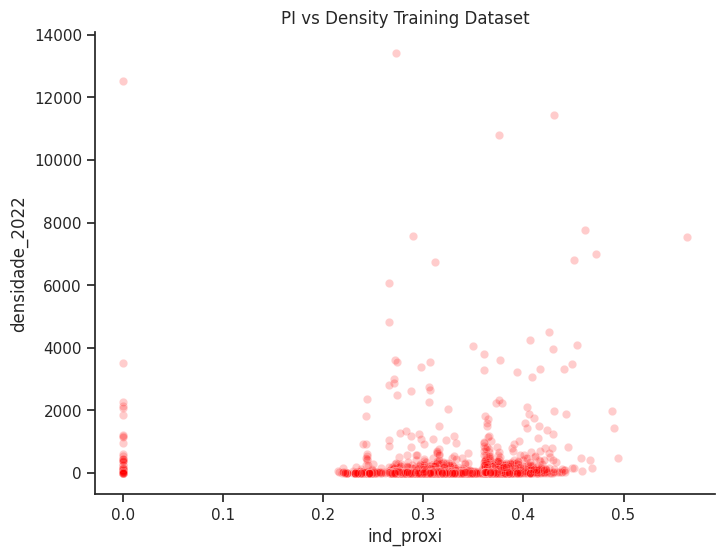

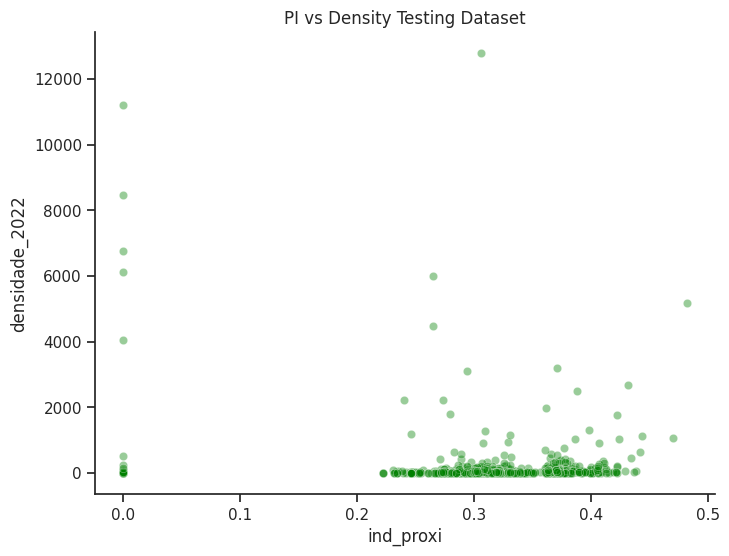

In [72]:
import matplotlib.pyplot as plt
import seaborn as sns  
sns.set_theme(style="ticks", rc={"axes.spines.right": False, "axes.spines.top": False})
 
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_train['ind_proxi'], y=y_train['densidade_2022'], color="red",alpha=0.2)
plt.title("PI vs Density Training Dataset")
 
plt.figure(figsize=(8,6))
sns.scatterplot(x=X_test['ind_proxi'], y=y_test['densidade_2022'], color="green",alpha=0.4)
plt.title("PI vs Density Testing Dataset")
 
plt.show()

In [84]:
X_train.describe()

,ind_proxi
count,4456.000000
mean,0.312984
std,0.070445
min,0.000000
25%,0.295167
50%,0.314057
75%,0.361508
max,0.563410


In [85]:
from patsy import dmatrix
transformed_x = dmatrix("bs(train, knots=(0.295167,0.314057,0.361508), degree=3, include_intercept=False)",
                        {"train": X_train},return_type='dataframe')

In [86]:
import statsmodels.api as sm
cs = sm.GLM(y_train, transformed_x).fit()
pred_test = cs.predict(dmatrix("bs(test, knots=(0.295167,0.314057,0.361508), include_intercept=False)",
                               {"test": X_test}, return_type='dataframe'))
rmse_test =mean_squared_error(y_test, pred_test, squared=False)
print("Accuracy for Cubic Spline on testing data is : ",rmse_test)

Accuracy for Cubic Spline on testing data is :  779.2890571018643


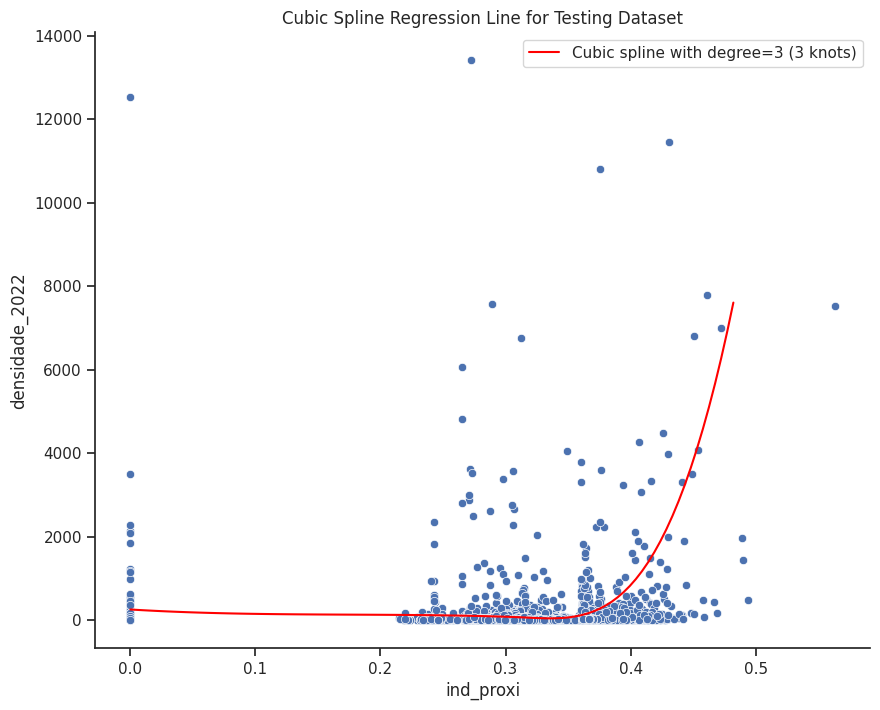

In [87]:
import numpy as np
plt.figure(figsize=(10,8))
xp = np.linspace(X_test.min(),X_test.max(), 100)
pred = cs.predict(dmatrix("bs(xp, knots=(0.295167,0.314057,0.361508), include_intercept=False)", 
                          {"xp": xp}, return_type='dataframe'))
sns.scatterplot(x=X_train['ind_proxi'], y=y_train['densidade_2022']) #x=X_test['ind_proxi'], y=y_test['densidade_2022']
plt.plot(xp, pred, label='Cubic spline with degree=3 (3 knots)', color='red')
plt.legend()
plt.title("Cubic Spline Regression Line for Testing Dataset")
plt.show()

In [56]:
data.groupby(['Nome_UF','hub_ind_proxi'])['populacao_2022'].sum().reset_index()

,Nome_UF,hub_ind_proxi,populacao_2022
0,Acre,0.0,423921
1,Acre,1.0,406105
2,Alagoas,0.0,1245190
3,Alagoas,1.0,1882321
4,Amapá,0.0,733508
5,Amazonas,0.0,3941175
6,Bahia,0.0,3969842
7,Bahia,1.0,10166575
8,Ceará,0.0,3658441
9,Ceará,1.0,5133247


In [57]:
data.groupby(['Nome_UF','hub_ind_intermed'])['populacao_2022'].sum().reset_index()

,Nome_UF,hub_ind_intermed,populacao_2022
0,Acre,0.0,332033
1,Acre,1.0,497993
2,Alagoas,0.0,1379392
3,Alagoas,1.0,1748119
4,Amapá,0.0,290575
5,Amapá,1.0,442933
6,Amazonas,0.0,1601418
7,Amazonas,1.0,2339757
8,Bahia,0.0,5348181
9,Bahia,1.0,8788236
